# Evaluation

In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [62]:
import asyncio
import logging
import os
import re
import sys
import warnings
from pathlib import Path
from typing import Optional

import matplotlib.pyplot as plt
import nest_asyncio
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from nltk.translate.bleu_score import SmoothingFunction, sentence_bleu
from rouge import Rouge
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

ROOT_FOLDERS = [os.path.join(".", ".."), os.path.join(".", "..", "..")]
for folder in ROOT_FOLDERS:
    if folder not in sys.path:
        sys.path.insert(0, folder)

from src.pipeline import ApiModel, Indexer, IndexerPipeline, RAGPipeline
from src.utils import from_current_file, load, load_json, remove_path, save_json

warnings.filterwarnings("ignore")
logging.disable(logging.WARNING)

nest_asyncio.apply()

## Utils

In [19]:
DATA_PATH = from_current_file("../data/scrapped/class_data_function__1_1")

NAME_TO_IDX = {
    filename[:-4]: document_id
    for document_id, filename in enumerate(os.listdir(DATA_PATH))
}
IDX_TO_NAME = {v: k for k, v in NAME_TO_IDX.items()}

In [20]:
INDEXER_PIPELINE = IndexerPipeline()
RAG_PIPELINE = RAGPipeline()

In [51]:
LLM_RES_PATH = from_current_file("../data/evaluation/llm_responses.json")
QUERIES_PATH = from_current_file("../data/evaluation/queries.json")
INDEXER_RES_PATH = from_current_file("../data/evaluation/indexer_responses.json")

LLM_METRICS_PATH = from_current_file("../data/evaluation/llm_metrics.json")
GENERAl_METRICS_PATH = from_current_file("../data/evaluation/general_metrics.json")

PICTURES_PATH = from_current_file("../pictures/evaluation")

## Load queries

In [22]:
def load_queries(
    path: Path = QUERIES_PATH,
) -> list[tuple[str, str, list[str]]]:
    return [(k, v["query"], v["ground_truths"]) for k, v in load_json(path).items()]


queries = load_queries()
# queries

In [23]:
def check_validity():
    queries = load_queries()

    for _, __, ground_truths in tqdm(queries):
        for gt in ground_truths:
            if gt not in NAME_TO_IDX:
                raise RuntimeError(f"Invalid ground truth: {gt}")


check_validity()

100%|██████████| 24/24 [00:00<00:00, 181375.31it/s]


## Generate responses

### Indexers

In [25]:
def generate_indexer_responses(
    indexer_res_path: Path = INDEXER_RES_PATH,
    force: bool = False,
) -> dict:
    queries = load_queries()

    indexers = INDEXER_PIPELINE.available_indexers
    if force:
        remove_path(indexer_res_path)
    indexer_responses = load_json(indexer_res_path, allow_empty=True)

    for query_name, query, ground_truths in tqdm(queries):
        for indexer in indexers:
            if indexer not in indexer_responses:
                indexer_responses[indexer] = {}
            if query_name in indexer_responses[indexer]:
                continue
            _, docs_scores = INDEXER_PIPELINE.index(query, indexer, k=10)
            docs = [doc for doc, _ in docs_scores]
            indexer_responses[indexer][query_name] = {
                "query": query_name,
                "responses": docs,
                "responses_idx": [NAME_TO_IDX[d] for d in docs],
                "ground_truths": ground_truths,
                "ground_truths_idx": [NAME_TO_IDX[d] for d in ground_truths],
            }
    save_json(indexer_res_path, indexer_responses)
    return indexer_responses


indexer_responses = generate_indexer_responses()

100%|██████████| 24/24 [00:00<00:00, 657930.04it/s]


### LLM

In [26]:
def extract_from_response(text: str) -> list[int]:
    try:
        # Find all matches
        ref_matches = re.findall(r"\[(\d+(?:,\s*\d+)*)\]", text.split("References:")[1])
        # ref_matches = re.findall(pattern, text)

        # Extract individual numbers
        numbers = []
        for match in ref_matches:
            numbers.extend([num.strip() for num in match.split(",")])

        # Convert to integers
        numbers = list(map(int, numbers))
        return numbers
    except BaseException:
        return []

In [27]:
async def access_llm(
    query: str, model: ApiModel, indexer: Indexer, model_name: str, k=10
) -> tuple[str, list[str], str, Optional[str]]:
    try:
        response, sources = await RAG_PIPELINE.request_async(
            query, model, k=k, indexer=indexer
        )
        return response, sources, model_name, None
    except Exception as e:
        return "", [], model_name, str(e)

In [29]:
async def generate_llm_responses(
    models: list[ApiModel],
    timeout: float = 60.0,
    llm_res_path: Path = LLM_RES_PATH,
    force: bool = False,
) -> dict:
    queries = load_queries()

    indexers = INDEXER_PIPELINE.available_indexers
    if force:
        remove_path(llm_res_path)

    llm_responses = load_json(llm_res_path, allow_empty=True)

    for query_name, query, ground_truths in tqdm(queries):
        results = []
        for model in models:
            for indexer in indexers:
                model_name = f"{model} + {indexer}"
                if model_name not in llm_responses:
                    llm_responses[model_name] = {}
                if query_name in llm_responses[model_name]:
                    continue

                results.append(access_llm(query, model, indexer, model_name))

        for coro in asyncio.as_completed(results):
            try:
                llm_res, sources, model_name, err = await asyncio.wait_for(coro, timeout)
                if err is not None:
                    continue
                local_indices = extract_from_response(llm_res)
                docs = [sources[idx - 1] for idx in local_indices]
                llm_responses[model_name][query_name] = {
                    "query": query_name,
                    "llm_output": llm_res,
                    "sources": sources,
                    "sources_idx": [NAME_TO_IDX[d] for d in sources],
                    "responses": docs,
                    "responses_idx": [NAME_TO_IDX[d] for d in docs],
                    "ground_truths": ground_truths,
                    "ground_truths_idx": [NAME_TO_IDX[d] for d in ground_truths],
                }
            except asyncio.TimeoutError:
                continue
            except BaseException:
                continue
        if len(results) > 0:
            await asyncio.sleep(2)

    save_json(llm_res_path, llm_responses)
    return llm_responses


llm_responses = await generate_llm_responses(["evil", "qwen-2-72b"])

100%|██████████| 24/24 [00:00<00:00, 122164.19it/s]

## Compute metrics

### LLM

In [12]:
def cosine_sim(a, b):
    return cosine_similarity([a], [b])[0][0]

In [13]:
def build_context(doc_names: list[str]) -> list[str]:
    return [load(os.path.join(DATA_PATH, f"{doc_name}.txt")) for doc_name in doc_names]


def compute_query_llm_metrics(query_result: dict, get_embedding):
    rouge = Rouge()
    smooth = SmoothingFunction().method1

    query = query_result["query"]
    llm_output = query_result["llm_output"]
    contexts = build_context(query_result["responses"])
    ground_truths = "\n".join(query_result["ground_truths"])

    emb_query = get_embedding(query)
    emb_llm_output = get_embedding(llm_output)
    emb_ground_truths = get_embedding(ground_truths)
    emb_contexts = [get_embedding(c) for c in contexts]
    emb_context_all = get_embedding(" ".join(contexts))

    # 1. faithfulness: answer vs context
    faithfulness_score = cosine_sim(emb_llm_output, emb_context_all)

    # 2. answer relevancy: answer vs question
    answer_relevancy_score = cosine_sim(emb_llm_output, emb_query)

    # 3. context recall: ground truth vs context
    context_recall_score = cosine_sim(emb_ground_truths, emb_context_all)

    # 4. context precision: answer vs each context (max similarity)
    precisions = [cosine_sim(emb_llm_output, ctx_emb) for ctx_emb in emb_contexts]
    context_precision_score = np.max(precisions) if precisions else 0.0

    # 5. BLEU: answer vs ground truth
    bleu_score = sentence_bleu(
        [nltk.word_tokenize(ground_truths.lower())],
        nltk.word_tokenize(llm_output.lower()),
        smoothing_function=smooth,
        weights=(0.5, 0.5),  # BLEU-2
    )

    # 6. ROUGE: answer vs ground truth
    rouge_scores = rouge.get_scores(llm_output, ground_truths)[0]
    rouge1 = rouge_scores["rouge-1"]["f"]
    rougeL = rouge_scores["rouge-l"]["f"]

    return {
        "faithfulness": round(faithfulness_score, 3),
        "answer_relevancy": round(answer_relevancy_score, 3),
        "context_recall": round(context_recall_score, 3),
        "context_precision": round(context_precision_score, 3),
        "bleu": round(bleu_score, 3),
        "rouge1": round(rouge1, 3),
        "rougeL": round(rougeL, 3),
    }

In [14]:
def compute_llm_metrics(
    llm_metrics_path: Path = LLM_METRICS_PATH,
    llm_res_path: Path = LLM_RES_PATH,
    force: bool = False,
) -> dict:
    model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

    llm_responses = load_json(llm_res_path)

    if force:
        remove_path(llm_metrics_path)

    llm_metrics = load_json(llm_metrics_path, allow_empty=True)

    for model_name, queries in llm_responses.items():
        for query_name, query_res in tqdm(queries.items(), desc=model_name):
            if model_name not in llm_metrics:
                llm_metrics[model_name] = {}
            if query_name in llm_metrics[model_name]:
                continue
            llm_metrics[model_name][query_name] = compute_query_llm_metrics(
                query_res, get_embedding=lambda x: model.encode([x])[0]
            )
        # Compute mean
        llm_metrics[model_name]["mean"] = {
            k: np.mean(
                [v[k] for v in llm_metrics[model_name].values() if isinstance(v, dict)]
            )
            for k in list(llm_metrics[model_name].values())[0].keys()
        }

    save_json(llm_metrics_path, llm_metrics)

    return llm_metrics


general_metrics = compute_llm_metrics()

qwen-2-72b + llm_tree_idx: 100%|██████████| 24/24 [00:00<00:00, 122016.12it/s]


### General

In [15]:
def precision_at_k(ground_truth, predicted, k):
    """Compute Precision@k"""
    if k == 0:
        return 0.0
    predicted = predicted[:k]
    relevant = set(ground_truth)
    hits = sum(1 for item in predicted if item in relevant)
    return hits / k


def recall_at_k(ground_truth, predicted, k):
    """Compute Recall@k"""
    if not ground_truth:
        return 0.0
    predicted = predicted[:k]
    relevant = set(ground_truth)
    hits = sum(1 for item in predicted if item in relevant)
    return hits / len(ground_truth)


def ap_at_k(ground_truth, predicted, k):
    """Compute Average Precision@k"""
    if not ground_truth or k == 0:
        return 0.0

    predicted = predicted[:k]
    relevant = set(ground_truth)
    hits = 0
    sum_precisions = 0.0

    for i, item in enumerate(predicted, 1):
        if item in relevant:
            hits += 1
            sum_precisions += hits / i

    return sum_precisions / min(len(ground_truth), k)


def map_at_k(ground_truth_list, predicted_list, k):
    """Compute Mean Average Precision@k across multiple queries"""
    return np.mean(
        [ap_at_k(gt, pred, k) for gt, pred in zip(ground_truth_list, predicted_list)]
    )


def recall_rate_at_k(ground_truth_list, predicted_list, k):
    """Compute Mean Recall Rate@k across multiple queries"""
    return np.mean(
        [
            recall_at_k(gt, pred[:k], k)
            for gt, pred in zip(ground_truth_list, predicted_list)
        ]
    )


def dcg_at_k(ground_truth, predicted, k):
    """Compute Discounted Cumulative Gain@k"""
    predicted = predicted[:k]
    relevant = set(ground_truth)
    gains = [
        1.0 / np.log2(i + 2) if item in relevant else 0.0
        for i, item in enumerate(predicted)
    ]
    return sum(gains)


def ndcg_at_k(ground_truth, predicted, k):
    """Compute Normalized DCG@k"""
    idcg = dcg_at_k(ground_truth, ground_truth, k)
    if idcg == 0:
        return 0.0
    dcg = dcg_at_k(ground_truth, predicted, k)
    return dcg / idcg


def mean_ndcg_at_k(ground_truth_list, predicted_list, k):
    """Compute Mean nDCG@k across multiple queries"""
    return np.mean(
        [ndcg_at_k(gt, pred, k) for gt, pred in zip(ground_truth_list, predicted_list)]
    )


def mrr_at_k(ground_truth_list, predicted_list, k):
    """Compute Mean Reciprocal Rank@k across multiple queries"""
    rr_scores = []
    for gt, pred in zip(ground_truth_list, predicted_list):
        pred = pred[:k]
        relevant = set(gt)
        for i, item in enumerate(pred, 1):
            if item in relevant:
                rr_scores.append(1.0 / i)
                break
        else:
            rr_scores.append(0.0)
    return np.mean(rr_scores)


def f1_at_k(ground_truth_list, predicted_list, k):
    """Compute F1-score@k across multiple queries"""
    f1_scores = []
    for gt, pred in zip(ground_truth_list, predicted_list):
        p = precision_at_k(gt, pred, k)
        r = recall_at_k(gt, pred, k)
        if (p + r) == 0:
            f1_scores.append(0.0)
        else:
            f1_scores.append(2 * (p * r) / (p + r))
    return np.mean(f1_scores)


def compute_query_general_metrics(
    ground_truth_list: list[list[int]], results_list: list[list[int]], k_values: list[int]
) -> dict:
    results = {
        str(k): {
            "MAP": map_at_k(ground_truth_list, results_list, k),
            "MAR": recall_rate_at_k(ground_truth_list, results_list, k),
            "nDCG": mean_ndcg_at_k(ground_truth_list, results_list, k),
            "MRR": mrr_at_k(ground_truth_list, results_list, k),
            "F1": f1_at_k(ground_truth_list, results_list, k),
        }
        for k in k_values
    }

    return results

In [16]:
def compute_general_metrics(
    general_metrics_path: Path = GENERAl_METRICS_PATH,
    llm_res_path: Path = LLM_RES_PATH,
    indexer_res_path: Path = INDEXER_RES_PATH,
    k_values: list[int] = [1, 3, 5, 10],
    force: bool = False,
) -> dict:
    llm_responses = load_json(llm_res_path)
    indexer_responses = load_json(indexer_res_path)

    if force:
        remove_path(general_metrics_path)

    general_metrics = load_json(general_metrics_path, allow_empty=True)

    for model_name, queries in [*llm_responses.items(), *indexer_responses.items()]:
        ground_truth_list, responses_list = [], []
        for query_name, query_res in tqdm(queries.items(), desc=model_name):
            if model_name not in general_metrics:
                general_metrics[model_name] = {}

            ground_truth_list.append(query_res["ground_truths_idx"])
            responses_list.append(query_res["responses_idx"])
        general_metrics[model_name] = compute_query_general_metrics(
            ground_truth_list, responses_list, k_values
        )

    save_json(general_metrics_path, general_metrics)

    return general_metrics


general_metrics = compute_general_metrics()

general_metrics

evil + llm_tree_idx:   0%|          | 0/24 [00:00<?, ?it/s]

llm_tree_idx: 100%|██████████| 24/24 [00:00<00:00, 319566.02it/s]


{'evil + inverted_idx': {'1': {'MAP': 0.2916666666666667,
   'MAR': 0.11284722222222221,
   'nDCG': 0.2916666666666667,
   'MRR': 0.2916666666666667,
   'F1': 0.14953703703703702},
  '3': {'MAP': 0.16898148148148148,
   'MAR': 0.14756944444444445,
   'nDCG': 0.19943100032593122,
   'MRR': 0.2916666666666667,
   'F1': 0.1323773448773449},
  '5': {'MAP': 0.15387731481481481,
   'MAR': 0.1579861111111111,
   'nDCG': 0.1870040812834205,
   'MRR': 0.2916666666666667,
   'F1': 0.1085927960927961},
  '10': {'MAP': 0.1507523148148148,
   'MAR': 0.1579861111111111,
   'nDCG': 0.1834116853456722,
   'MRR': 0.2916666666666667,
   'F1': 0.06768463018463018}},
 'evil + llm_tree_idx': {'1': {'MAP': 0.8333333333333334,
   'MAR': 0.4288194444444444,
   'nDCG': 0.8333333333333334,
   'MRR': 0.8333333333333334,
   'F1': 0.5342592592592593},
  '3': {'MAP': 0.5648148148148148,
   'MAR': 0.5517361111111111,
   'nDCG': 0.649941831072539,
   'MRR': 0.8888888888888888,
   'F1': 0.4362463924963926},
  '5': {'M

## Generate plots

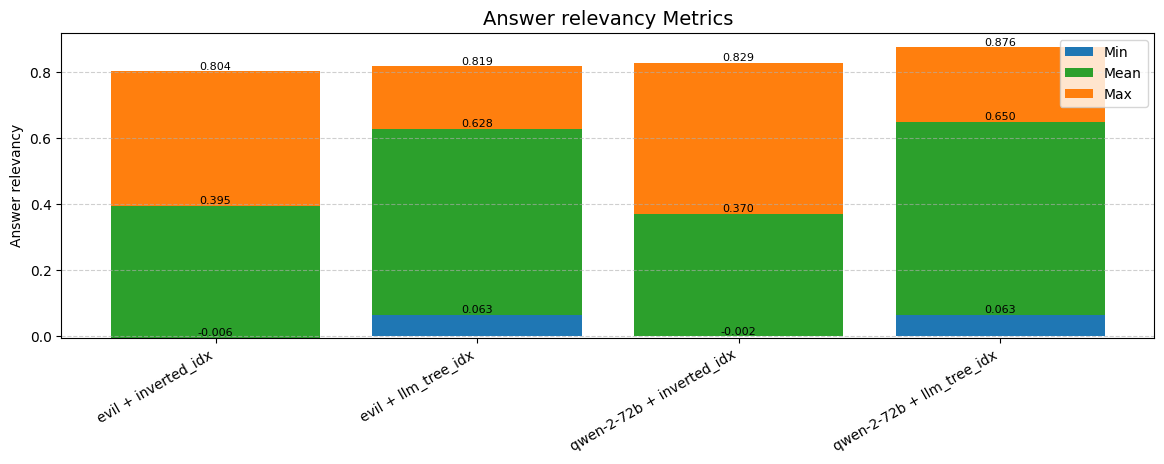

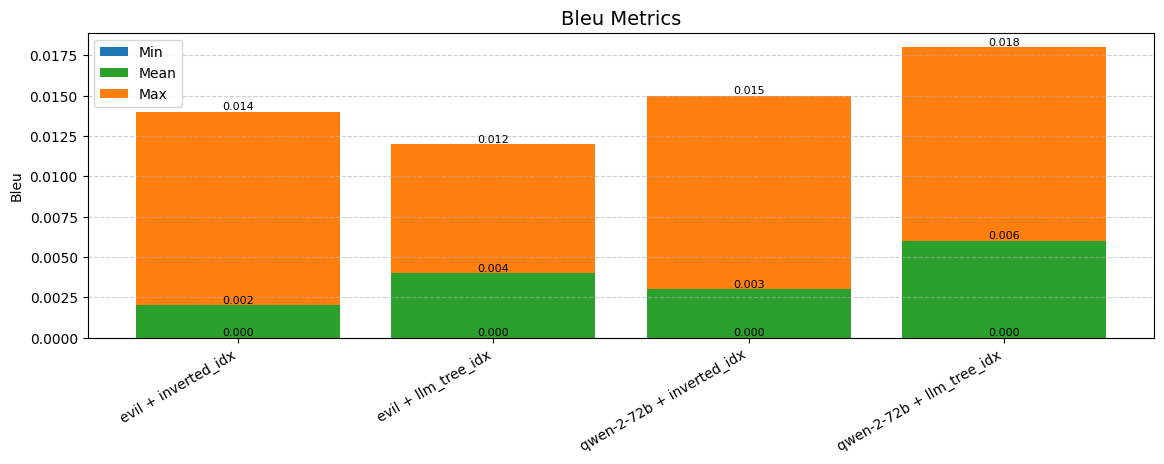

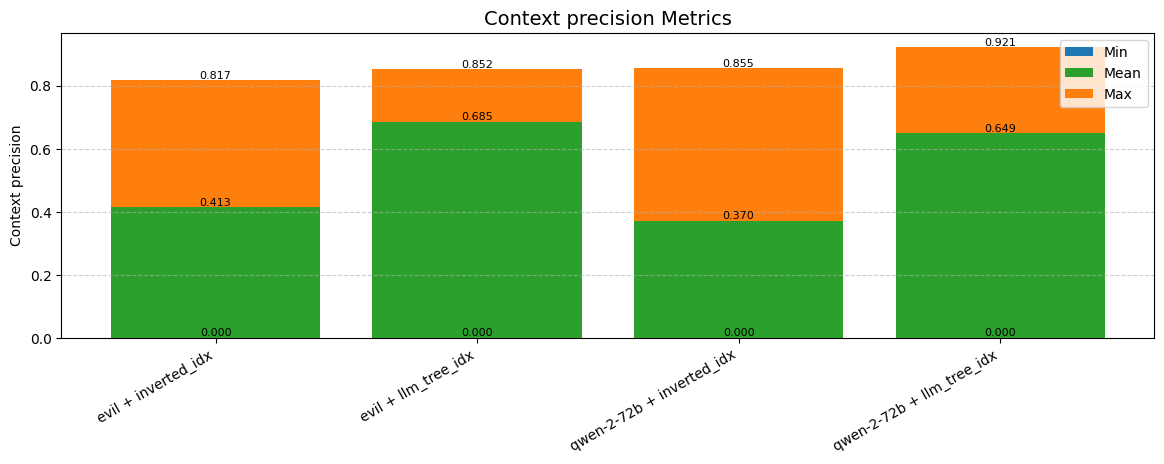

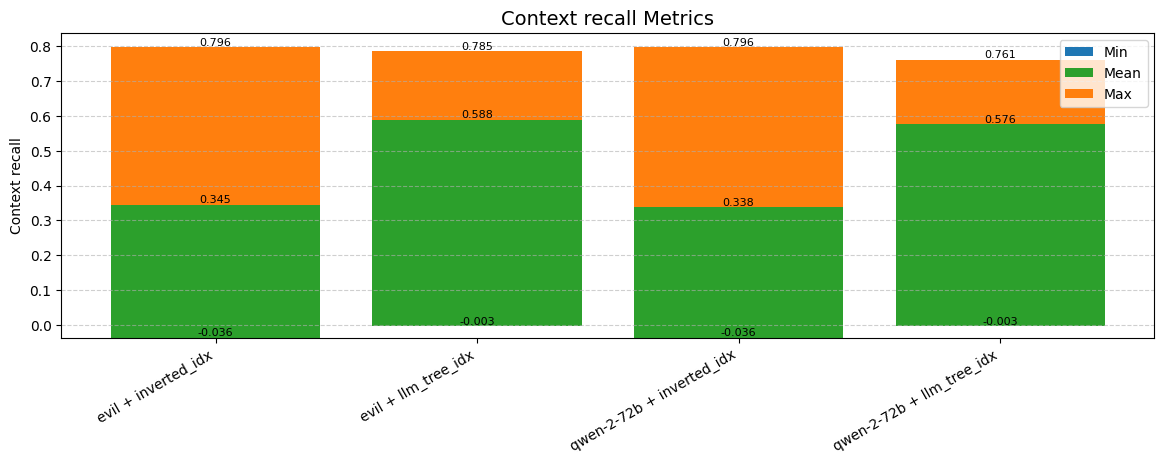

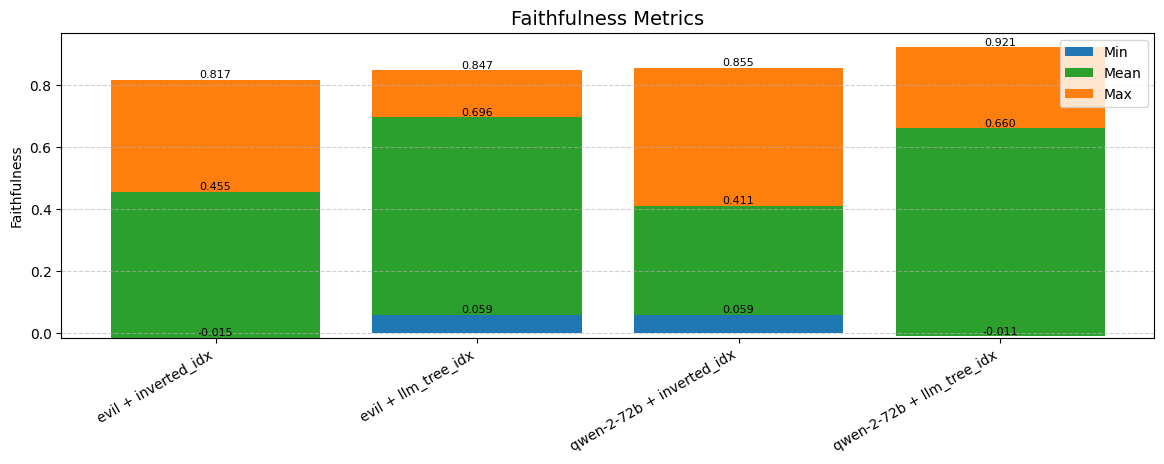

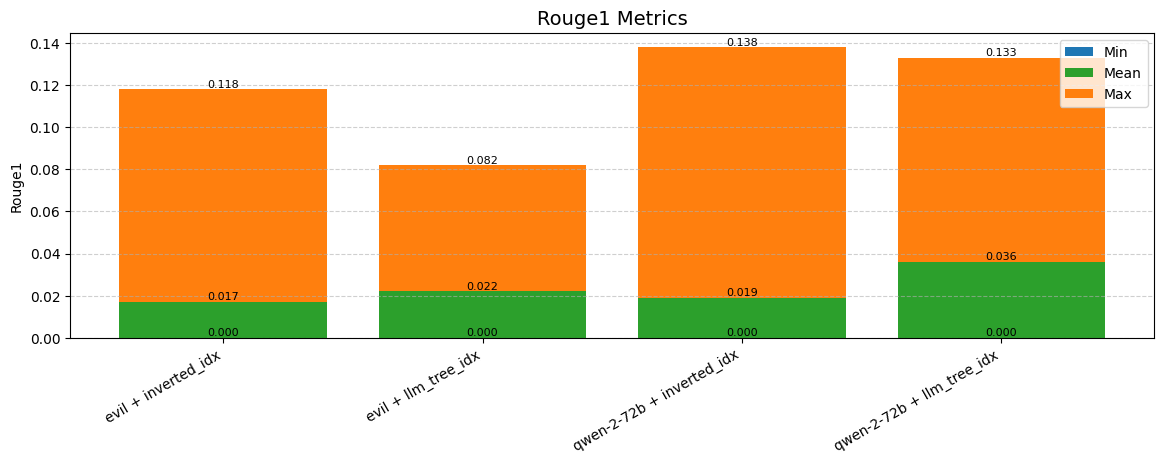

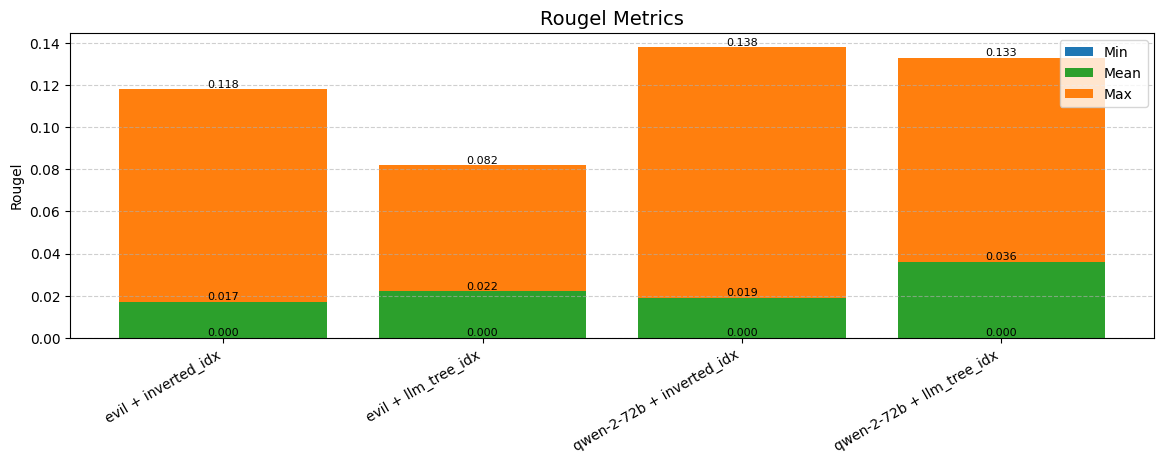

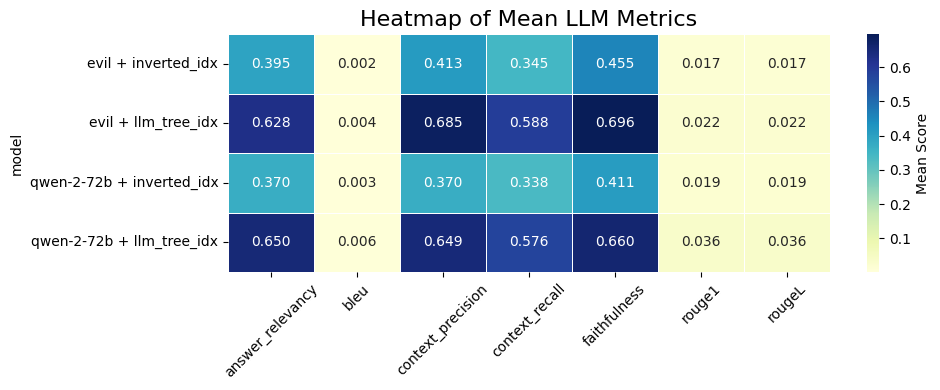

In [86]:
def plot_llm_metrics(
    llm_metrics_path: Path = LLM_METRICS_PATH,
    pictures_path: Path = PICTURES_PATH,
):
    os.makedirs(pictures_path, exist_ok=True)

    data = load_json(llm_metrics_path)

    # Extract mean, min, and max
    models = {}
    for model, metrics in data.items():
        mean = metrics.get("mean", {})
        queries = [v for k, v in metrics.items() if k != "mean" and isinstance(v, dict)]
        if not queries:
            continue

        query_df = pd.DataFrame(queries)
        models[model] = {
            "mean": mean,
            "min": query_df.min(numeric_only=True).to_dict(),
            "max": query_df.max(numeric_only=True).to_dict(),
        }

    # Structure into DataFrame
    metrics_set = set()
    for stats in models.values():
        metrics_set.update(stats["mean"].keys())

    rows = []
    for model, stats in models.items():
        row = {"model": model}
        for m in metrics_set:
            row[f"{m}_mean"] = stats["mean"].get(m, None)
            row[f"{m}_min"] = stats["min"].get(m, None)
            row[f"{m}_max"] = stats["max"].get(m, None)
        rows.append(row)

    df = pd.DataFrame(rows).set_index("model").round(3)
    metrics = sorted(set("_".join(col.split("_")[:-1]) for col in df.columns))

    # Plot stacked bars
    for metric in metrics:
        if f"{metric}_mean" not in df:
            continue

        min_vals = df[f"{metric}_min"]
        mean_vals = df[f"{metric}_mean"]
        max_vals = df[f"{metric}_max"]

        lower = min_vals
        middle = mean_vals - min_vals
        upper = max_vals - mean_vals

        x = df.index
        _, ax = plt.subplots(figsize=(12, max(5, len(x) * 0.4)))

        ax.bar(x, lower, label="Min", color="#1f77b4")
        ax.bar(x, middle, bottom=lower, label="Mean", color="#2ca02c")
        ax.bar(x, upper, bottom=mean_vals, label="Max", color="#ff7f0e")

        for i, model in enumerate(x):
            ax.text(
                i,
                lower[i],
                f"{lower[i]:.3f}",
                ha="center",
                va="bottom",
                fontsize=8,
                color="black",
            )
            ax.text(
                i,
                lower[i] + middle[i],
                f"{mean_vals[i]:.3f}",
                ha="center",
                va="bottom",
                fontsize=8,
                color="black",
            )
            ax.text(
                i,
                mean_vals[i] + upper[i],
                f"{max_vals[i]:.3f}",
                ha="center",
                va="bottom",
                fontsize=8,
                color="black",
            )

        metric_name = metric.replace("_", " ").capitalize()
        ax.set_title(f"{metric_name.capitalize()} Metrics", fontsize=14)
        ax.set_ylabel(metric_name.capitalize())
        ax.set_xticks(range(len(x)))
        ax.set_xticklabels(x, rotation=30, ha="right")
        ax.legend()
        ax.grid(axis="y", linestyle="--", alpha=0.6)

        plt.tight_layout(pad=2.0)

        plt.savefig(
            os.path.join(pictures_path, f"llm_{metric.lower()}.png"), bbox_inches="tight"
        )

        plt.show()

    # Seaborn heatmap of mean metrics
    mean_df = df[[col for col in df.columns if col.endswith("_mean")]].copy()
    mean_df = mean_df.sort_index()
    mean_df = mean_df[sorted(mean_df.columns)]
    mean_df.columns = [col.replace("_mean", "") for col in mean_df.columns]

    plt.figure(figsize=(max(10, len(mean_df.columns)), max(4, len(mean_df) * 0.4)))
    sns.heatmap(
        mean_df,
        annot=True,
        fmt=".3f",
        cmap="YlGnBu",
        linewidths=0.5,
        cbar_kws={"label": "Mean Score"},
    )
    plt.xticks(rotation=45)
    plt.title("Heatmap of Mean LLM Metrics", fontsize=16)
    plt.tight_layout()
    plt.savefig(os.path.join(pictures_path, "llm_mean_heatmap.png"), bbox_inches="tight")
    plt.show()


plot_llm_metrics()

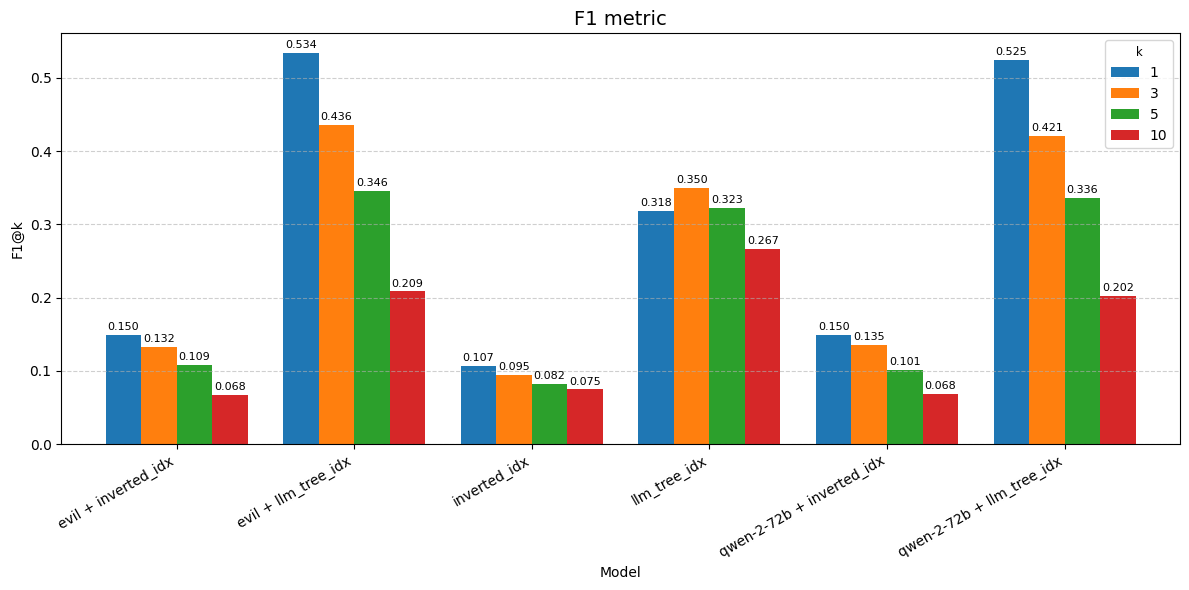

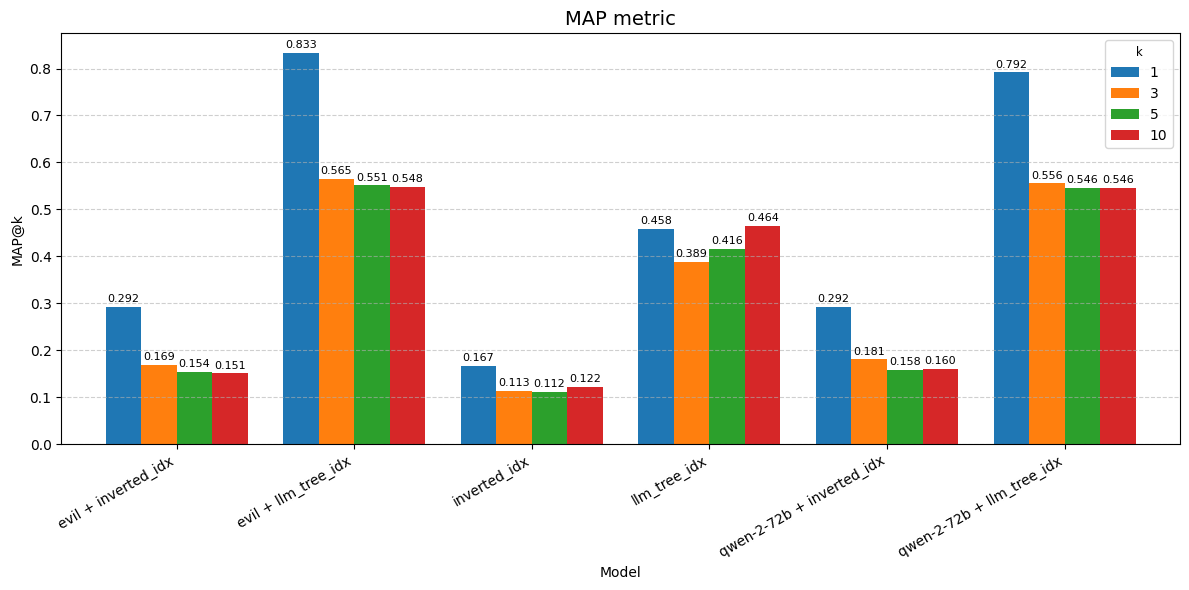

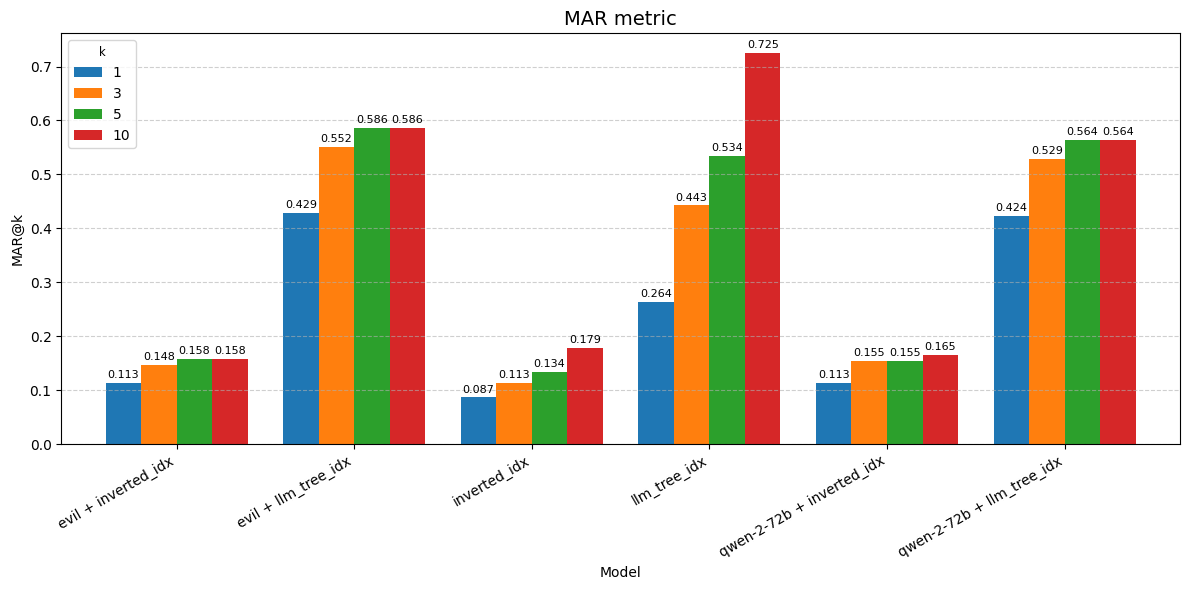

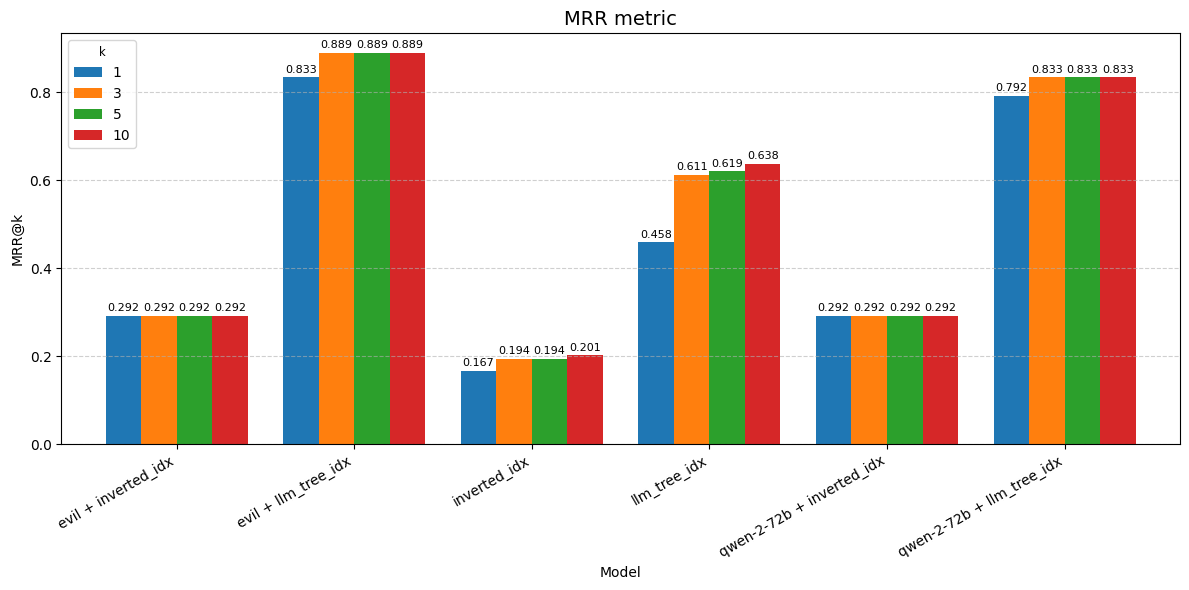

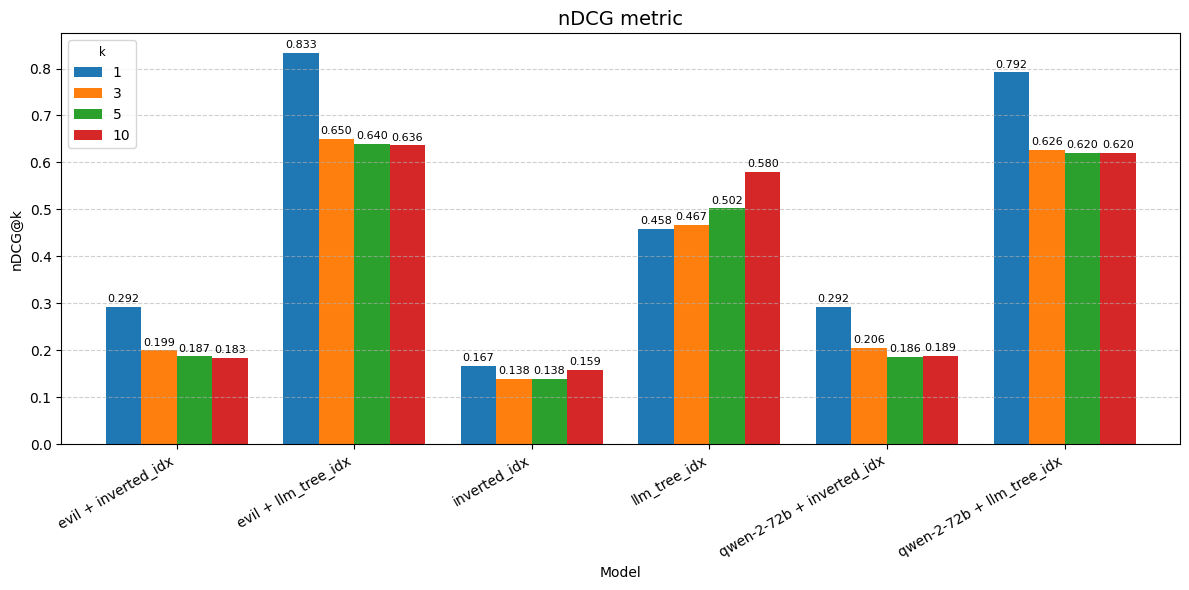

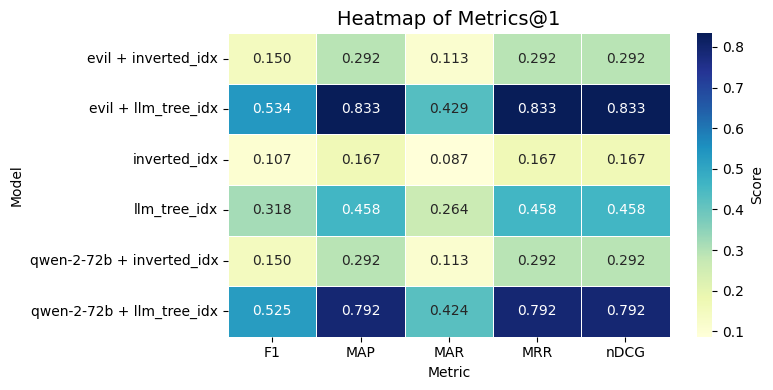

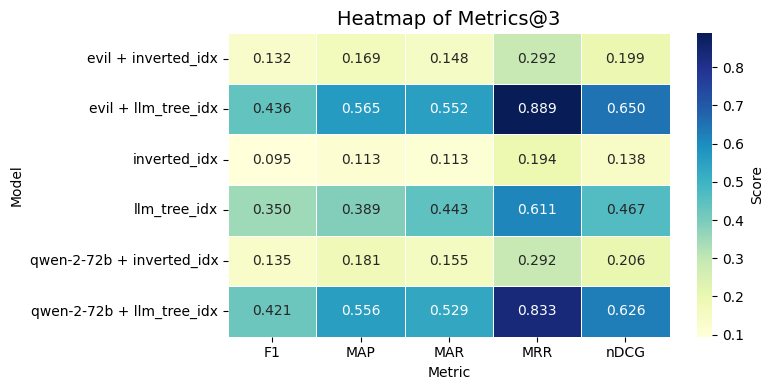

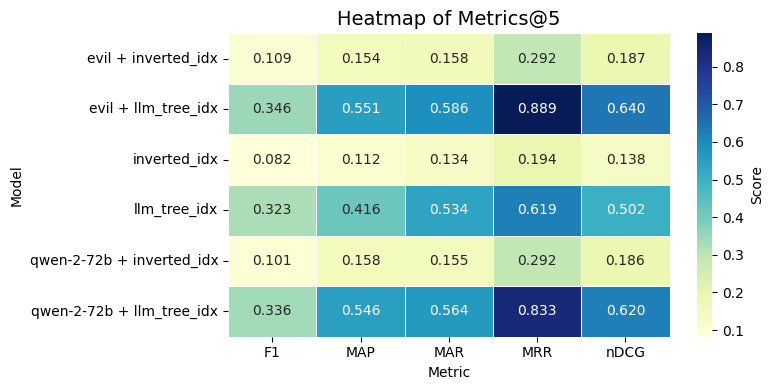

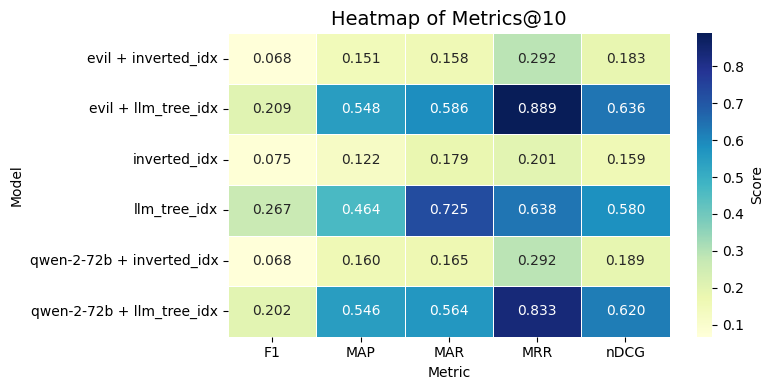

In [89]:
def plot_general_metrics(
    general_metrics_path: Path = GENERAl_METRICS_PATH,
    pictures_path: Path = PICTURES_PATH,
):
    os.makedirs(pictures_path, exist_ok=True)

    # Load JSON data
    data = load_json(general_metrics_path)

    # Flatten nested dict: model, n, metrics
    records = []
    for model, k_metrics in data.items():
        for k, metrics in k_metrics.items():
            row = {"model": model, "k": int(k)}
            row.update(metrics)
            records.append(row)

    df = pd.DataFrame(records)

    metrics = [col for col in df.columns if col not in ("model", "k")]
    models = sorted(df["model"].unique())
    ks = sorted(df["k"].unique())

    # Bar plots for each metric: grouped bars per model, grouped by n
    for metric in metrics:
        plt.figure(figsize=(max(12, len(models) * 0.9), 6))
        ax = plt.gca()

        pivot_df = df.pivot(index="model", columns="k", values=metric).loc[models]

        bars = pivot_df.plot(kind="bar", ax=ax, width=0.8)

        # Add number labels above each bar
        for container in bars.containers:
            for bar in container:
                height = bar.get_height()
                if not pd.isna(height):
                    ax.annotate(
                        f"{height:.3f}",
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 2),
                        textcoords="offset points",
                        ha="center",
                        va="bottom",
                        fontsize=8,
                    )

        ax.set_title(f"{metric} metric", fontsize=14)
        ax.set_xlabel("Model")
        ax.set_ylabel(f"{metric}@k")
        ax.grid(axis="y", linestyle="--", alpha=0.6)
        plt.xticks(rotation=30, ha="right")
        plt.legend(title="k", title_fontsize="small")
        plt.tight_layout()

        plt.savefig(
            os.path.join(pictures_path, f"general_{metric.lower()}.png"),
            bbox_inches="tight",
        )
        plt.show()

    # Seaborn heatmap for each n (k)
    for k in ks:
        heatmap_df = df[df["k"] == k].set_index("model")[metrics].loc[models]

        plt.figure(figsize=(max(8, len(metrics) * 1.2), max(4, len(models) * 0.4)))
        sns.heatmap(
            heatmap_df,
            annot=True,
            fmt=".3f",
            cmap="YlGnBu",
            linewidths=0.5,
            cbar_kws={"label": "Score"},
        )
        plt.title(f"Heatmap of Metrics@{k}", fontsize=14)
        plt.xlabel("Metric")
        plt.ylabel("Model")
        plt.tight_layout()

        plt.savefig(
            os.path.join(pictures_path, f"general_heatmap_{k}.png"), bbox_inches="tight"
        )
        plt.show()


plot_general_metrics()